In [122]:
import pandas as pd
from requests import get
import time
from datetime import datetime, timedelta
import math
from io import StringIO
import statistics as stats
import matplotlib.pyplot as plt

In [100]:
#This one returns bootstrap samples given an array; 
#Used a lot throughout the file.
#Also references Pirates of the Carribean....
def bootstrap_bill(array, num_bootstrap_samples=500):
    return np.random.choice(array, size=num_bootstrap_samples, replace=True)


#This one is only used once, to get the data I want out of the zipresponse.text
#The output is later sent hrough StringIO and then read in as a csv file to be manipulated.
#It's tough to describe without seeing exactly WHY it's necessary, save to say the
#substrings indicated below basically represent the left and right margins of the data I
#actually want, so I use them to define the bounds of what I want, then replace the internal
#pipe with a line to be better recognized as the delineator between columns in the csv.
def fetch_csv_data(strinput):
    # initializing substrings
    sub1 = "var plotData = "
    sub2 = '";\r\n  var color1'
    
    # getting index of substrings
    idx1 = strinput.index(sub1)
    idx2 = strinput.index(sub2)
    
    res = ''
    # getting elements in between
    for idx in range(idx1 + len(sub1) + 1, idx2):
        res = res + strinput[idx]

    final_out = res.replace("|","\n")
    
    # get result
    return final_out


#Given a string that represents time, in YYYY mm dd hh:mm:ss format,
#this function spits out a datetime object. This became particularly
#pertinent, as without it, when trying to graph time, it understands
#the unmanipulated 'datetime' as a string; arbitrary and categorical
#in nature. This resulted in graphing times completely out of order,
#hence necessitating a function to be called on later.
def time_parser(datalst):
    new_time = None

    given_string_time = datalst
    date_format = '%Y-%m-%d %H:%M:%S'

    new_time = datetime.strptime(given_string_time, date_format)
    return new_time


#Given the orbital parameters from our dataset, this function creates
#an additional column for each column already present, now calculating
#how much the given parameter has changed since the last observation.
#i.e. if date/time at index1 was 2024-08-08 12:00:00 and date/time at 
#index2 was 2024-08-08 13:00:00, date/time delta at index 2 would be 
#3600 seconds since that represents the time between the two observations.
def show_deltas(dataframe):
    for col in dataframe.columns[:7]:
            dataframe[f'{col} Delta']= None
            for i in range(1,len(dataframe[f'{col} Delta'])):
                dataframe[f'{col} Delta'].iloc[i] = abs(dataframe[col].iloc[i] - dataframe[col].iloc[i-1])


#Given an array, this function will return a random choice provided it
#is within one standard deviation of the mean of the dataset.
#particularly important when modeling consistent motion for a satellite
#later on; otherwise, we'd have a hgiher propensity to superimpose maneuvers
#over a satellite instead of just imposing natural motion to see when the vehicle
#will meet conditions consistent with when it regularly maneuvers.
def standardized_choice(array): 
    contextualmean= np.mean(array)
    contextualstd= stats.stdev(array)
    #arbitrarily low number so that it will always be replaced, but can be 
    #compared with < and > to initiate the while loop.
    outcome= -100000000000
    while outcome > contextualmean + contextualstd or outcome < contextualmean - contextualstd:
        outcome = bootstrap_bill(array,1)[0]
    return outcome


#This defines the bounds of a standard deviation given an array.
#also givcen the option to choose high/low bounds and how many deviations
#from the mean you want to capture.
def stdev(array,dev=1):
    bootstrap= bootstrap_bill(array)
    mean=np.mean(bootstrap)
    stdev= stats.stdev(bootstrap)
    outcome= mean + stdev*dev
    return outcome




#This is honestly much ado for nothing...
#The abbreviation on the left is how NORAD satellite catalog information 
#comes naturally. In putting that into a set and then making a human-readable
#equivalent as the value for each, I can call the value just given the column
#so the name of the satellite owner appears in one line of block text
#when the application is first run.
sat_owner_set= {"AB":	"the Arab Satellite Communications Organization"
                ,"ABS":	"Asia Broadcast Satellite"
                ,"AC":	"Asia Satellite Telecommunications Company (ASIASAT)"
                ,"ALG":	"Algeria"
                ,"ANG":	"Angola"
                ,"ARGN":	"Argentina"
                ,"ARM":	"the Republic of Armenia"
                ,"ASRA":	"Austria"
                ,"AUS":	"Australia"
                ,"AZER":	"Azerbaijan"
                ,"BEL":	"Belgium"
                ,"BELA":	"Belarus"
                ,"BERM":	"Bermuda"
                ,"BGD":	"the Peoples Republic of Bangladesh"
                ,"BHUT":	"the Kingdom of Bhutan"
                ,"BOL":	"Bolivia"
                ,"BRAZ":	"Brazil"
                ,"BUL":	"Bulgaria"
                ,"CA":	"Canada"
                ,"CHBZ":	"China/Brazil"
                ,"CHTU":	"China/Turkey"
                ,"CHLE":	"Chile"
                ,"CIS":	"the Commonwealth of Independent States (former USSR)"
                ,"COL":	"Colombia"
                ,"CRI":	"the Republic of Costa Rica"
                ,"CZCH":	"the Czech Republic (former Czechoslovakia)"
                ,"DEN":	"Denmark"
                ,"DJI":	"the Republic of Djibouti"
                ,"ECU":	"Ecuador"
                ,"EGYP":	"Egypt"
                ,"ESA":	"the European Space Agency"
                ,"ESRO":	"the European Space Research Organization"
                ,"EST":	"Estonia"
                ,"ETH":	"Ethiopia"
                ,"EUME":	"the European Organization for the Exploitation of Meteorological Satellites (EUMETSAT)"
                ,"EUTE":	"the European Telecommunications Satellite Organization (EUTELSAT)"
                ,"FGER":	"France/Germany"
                ,"FIN":	"Finland"
                ,"FR":	"France"
                ,"FRIT":	"France/Italy"
                ,"GER":	"Germany"
                ,"GHA":	"the Republic of Ghana"
                ,"GLOB":	"Globalstar"
                ,"GREC":	"Greece"
                ,"GRSA":	"Greece/Saudi Arabia"
                ,"GUAT":	"Guatemala"
                ,"HUN":	"Hungary"
                ,"IM":	"the International Mobile Satellite Organization (INMARSAT)"
                ,"IND":	"India"
                ,"INDO":	"Indonesia"
                ,"IRAN":	"Iran"
                ,"IRAQ":	"Iraq"
                ,"IRID":	"Iridium"
                ,"IRL":	"Ireland"
                ,"ISRA":	"Israel"
                ,"ISRO":	"the Indian Space Research Organisation"
                ,"ISS":	"the Intergovernmental Agreement of International Space Station"
                ,"IT":	"Italy"
                ,"ITSO":	"the International Telecommunications Satellite Organization (INTELSAT)"
                ,"JPN":	"Japan"
                ,"KAZ":	"Kazakhstan"
                ,"KEN":	"the Republic of Kenya"
                ,"LAOS":	"Laos"
                ,"LKA":	"the Democratic Socialist Republic of Sri Lanka"
                ,"LTU":	"Lithuania"
                ,"LUXE":	"Luxembourg"
                ,"MA":	"Morroco"
                ,"MALA":	"Malaysia"
                ,"MCO":	"the Principality of Monaco"
                ,"MDA":	"the Republic of Moldova"
                ,"MEX":	"Mexico"
                ,"MMR":	"the Republic of the Union of Myanmar"
                ,"MNG":	"Mongolia"
                ,"MUS":	"Mauritius"
                ,"NATO":	"the North Atlantic Treaty Organization (NATO)"
                ,"NETH":	"Netherlands"
                ,"NICO":	"New ICO"
                ,"NIG":	"Nigeria"
                ,"NKOR":	"the Democratic People's Republic of Korea (North Korea)"
                ,"NOR":	"Norway"
                ,"NPL":	"the Federal Democratic Republic of Nepal"
                ,"NZ":	"New Zealand"
                ,"O3B":	"O3b Networks"
                ,"ORB":	"ORBCOMM"
                ,"PAKI":	"Pakistan"
                ,"PERU":	"Peru"
                ,"POL":	"Poland"
                ,"POR":	"Portugal"
                ,"PRC":	"the People's Republic of China"
                ,"PRY":	"the Republic of Paraguay"
                ,"PRES":	"the People's Republic of China/the European Space Agency"
                ,"QAT":	"the State of Qatar"
                ,"RASC":	"RascomStar-QAF"
                ,"ROC":	"Taiwan (Republic of China)"
                ,"ROM":	"Romania"
                ,"RP":	"Philippines (Republic of the Philippines)"
                ,"RWA":	"Republic of Rwanda"
                ,"SAFR":	"South Africa"
                ,"SAUD":	"Saudi Arabia"
                ,"SDN":	"the Republic of Sudan"
                ,"SEAL":	"Sea Launch"
                ,"SES":	"SES"
                ,"SGJP":	"Singapore/Japan"
                ,"SING":	"Singapore"
                ,"SKOR":	"the Republic of Korea"
                ,"SPN":	"Spain"
                ,"STCT":	"Singapore/Taiwan"
                ,"SVN":	"Slovenia"
                ,"SWED":	"Sweden"
                ,"SWTZ":	"Switzerland"
                ,"TBD":	"To Be Determined"
                ,"THAI":	"Thailand"
                ,"TMMC":	"Turkmenistan/Monaco"
                ,"TUN":	"the Republic of Tunisia"
                ,"TURK":	"Turkey"
                ,"UAE":	"the United Arab Emirates"
                ,"UK":	"the United Kingdom"
                ,"UKR":	"Ukraine"
                ,"UNK":	"Unknown"
                ,"URY":	"Uruguay"
                ,"US":	"the United States of America"
                ,"USBZ":	"the United States of America/Brazil"
                ,"VAT":	"the Vatican City State"
                ,"VENZ":	"Venezuela"
                ,"VTNM":	"Vietnam"
                ,"ZWE":	"the Republic of Zimbabwe"}

In [101]:
zip_response = get(f"https://celestrak.org/NORAD/elements/graph-orbit-data.php?CATNR=42921")
data4csv = fetch_csv_data(zip_response.text)
in_data = StringIO(data4csv)
sat_mnvr_df = pd.read_csv(in_data,header=0,sep=',')

In [102]:
sat_mnvr_df = pd.read_csv(in_data,header=0,sep=',')

EmptyDataError: No columns to parse from file

In [103]:
sat_mnvr_df

Date      RAAN  Inclination  Arg of Perigee  \
0     2022-08-21T21:28:35.389056   29.7764       0.0497        281.2211   
1     2022-08-22T03:54:07.143552   27.8371       0.0497        285.1416   
2     2022-08-22T08:43:15.936960   26.4612       0.0498        287.9867   
3     2022-08-22T18:21:33.528960   23.5659       0.0498        293.8039   
4     2022-08-22T23:10:42.319776   22.0795       0.0498        296.8099   
...                          ...       ...          ...             ...   
1231  2025-02-16T19:45:34.796160  155.4048       0.0475         38.5498   
1232  2025-02-17T08:33:29.505600  151.2182       0.0473         46.6625   
1233  2025-02-17T08:33:29.505600  151.2182       0.0473         46.6625   
1234  2025-02-17T14:57:26.817984  148.7535       0.0474         51.1509   
1235  2025-02-18T02:09:21.988512  145.5965       0.0477         57.6495   

          SMA  Eccentricity  
0     591.646      0.001239  
1     591.646      0.001238  
2     591.645      0.001238  
3     591.644      0.001239  
4     591.644      0.001239  
...       ...           ...  
1231  572.744      0.001107  
1232  572.725      0.001107  
1233  572.725      0.001107  
1234  572.720      0.001104  
1235  572.704      0.001104  

[1236 rows x 6 columns]

In [104]:
#Housekeeping to turn the date in the dataframe into something more readable
for i in range(len(sat_mnvr_df['Date'])):
    sat_mnvr_df['Date'].iloc[i] = sat_mnvr_df['Date'].iloc[i].replace("T", " ")
for i in range(len(sat_mnvr_df['Date'])):
    sat_mnvr_df['Date'].iloc[i] = sat_mnvr_df['Date'][i][0:19]
for i in range(len(sat_mnvr_df['Date'])):
    sat_mnvr_df['Date'].iloc[i] = time_parser(sat_mnvr_df['Date'].iloc[i])
sat_mnvr_df = sat_mnvr_df.rename(columns={"Date":"Date/Time (UTC)"})

#What's given here innately is actually altitude, not Semimajor Axis. Thankfully,
#the quick addition of the Earths radius, 6378kms, resolves that issue!
for i in range(len(sat_mnvr_df['SMA'])):
    sat_mnvr_df['SMA'].iloc[i] += 6378

#quick orbital mechanics to deduce period, that is the seconds it takes for a 
#satellite to complete one orbit, from SMA. 
sat_mnvr_df['Period'] = None
for i in range(len(sat_mnvr_df['SMA'])):
    sat_mnvr_df['Period'].iloc[i] = 2*math.pi*math.sqrt((sat_mnvr_df['SMA'].iloc[i]**3)/398600.44189)

sat_mnvr_df=sat_mnvr_df.dropna()
#   

#Impute the timestamp used to justify when new requests would be appropriate again,
#then push this file up to data to be used later and continue the cycle as necessary!
sat_mnvr_df['Timestamp'] = datetime.now()
sat_mnvr_df['SATCAT Number'] = 42921
sat_mnvr_df = sat_mnvr_df.drop(columns=['Timestamp','SATCAT Number'])


#ensures our Date/Time is a datetime object using a function we made earlier
if isinstance(sat_mnvr_df['Date/Time (UTC)'].iloc[0], str):
    for i in range(len(sat_mnvr_df['Date/Time (UTC)'])):
        sat_mnvr_df['Date/Time (UTC)'].iloc[i] = time_parser(sat_mnvr_df['Date/Time (UTC)'].iloc[i])


#Given the orbital parameters from our dataset, this function creates
#an additional column for each column already present, now calculating
#how much the given parameter has changed since the last observation.
#i.e. if date/time at index1 was 2024-08-08 12:00:00 and date/time at 
#index2 was 2024-08-08 13:00:00, date/time delta at index 2 would be 
#3600 seconds since that represents the time between the two observations
for col in sat_mnvr_df.columns:
        sat_mnvr_df[f'{col} Delta']= None
        for i in range(1,len(sat_mnvr_df[f'{col} Delta'])):
            sat_mnvr_df[f'{col} Delta'].iloc[i] = abs(sat_mnvr_df[col].iloc[i] - sat_mnvr_df[col].iloc[i-1])

sat_mnvr_df = sat_mnvr_df.dropna()

#Gets rid of duplicate observations so our data chronologically increases.
for i in range(len(sat_mnvr_df['Date/Time (UTC) Delta'])):
    if sat_mnvr_df['Date/Time (UTC) Delta'].iloc[i] == '0:00:00':
        sat_mnvr_df['Date/Time (UTC) Delta'].iloc[i] = None
sat_mnvr_df = sat_mnvr_df.dropna()


#Turns the time between observations into seconds (also not a datetime object anymore!) and also 
#repeats above attemps to catch any duplicate observations and parse them out of the dataset. 
for i in range(len(sat_mnvr_df['Date/Time (UTC)'])):
    sat_mnvr_df['Date/Time (UTC) Delta'].iloc[i] = abs(sat_mnvr_df['Date/Time (UTC)'].iloc[i] - sat_mnvr_df['Date/Time (UTC)'].iloc[i-1]).total_seconds()
    if sat_mnvr_df['Date/Time (UTC) Delta'].iloc[i] == timedelta(seconds=0)\
    or sat_mnvr_df['Date/Time (UTC) Delta'].iloc[i] == 0:
        sat_mnvr_df['Date/Time (UTC) Delta'].iloc[i] = None
sat_mnvr_df = sat_mnvr_df.dropna()


#Here we instantiate a column indicating the detection of an E/W maneuver.
#This is determined using high changes in relative orbital elements, SMA and Eccentricity,
#with that data ultimately kept in check by ensuring it's not just due to an abnormal time
#between observations. You may notice that whereas SMA and Period just have to be above
#one standard deviation to be considered indicative of a maneuver, Eccentricity has only 0.5.
#Whereas radial maneuvers don't really change a satellites position, they do effect eccentricity, 
#so it's not necessarily uncommon to couple some degree of radial maneuver with E/W maneuvers to
#mitigate eccentricity changes.
sat_mnvr_df['E/W Maneuver'] = False
for i in range(len(sat_mnvr_df['SMA'])):
    if sat_mnvr_df['SMA Delta'].iloc[i] >= stats.stdev(sat_mnvr_df['SMA Delta'])*1\
    and sat_mnvr_df['Eccentricity Delta'].iloc[i] >= stats.stdev(sat_mnvr_df['Eccentricity Delta'])*.5\
    and sat_mnvr_df['Period Delta'].iloc[i] >= stats.stdev(sat_mnvr_df['Period Delta'])*1\
    and sat_mnvr_df['Date/Time (UTC) Delta'].iloc[i] <= stats.stdev(sat_mnvr_df['Date/Time (UTC) Delta'])*2:
        sat_mnvr_df['E/W Maneuver'].iloc[i-1] = True


#Here we instantiate a column indicating the detection of an N/S maneuver.
#This is determined using high changes in relative orbital elements, RAAN and Inclination,
#with that data ultimately kept in check by ensuring it's not just due to an abnormal time
#between observations. You may notice that we also ensure any changes to RAAN above 170 are not counted.
#this is because RAAN can sometimes flip 180 degrees as Inclination shifts, but additionally
#RAAN usually does a full 360 degree rotation over the course of a year, so we don't want
#to attribute it going from 360 to 1 as some massive maneuver, as these are only 1 degree
#from each other.
sat_mnvr_df['N/S Maneuver'] = False
for i in range(len(sat_mnvr_df['RAAN'])):
    if sat_mnvr_df['RAAN Delta'].iloc[i] >= stats.stdev(sat_mnvr_df['RAAN Delta'])*1\
    and sat_mnvr_df['RAAN Delta'].iloc[i] < 170\
    or sat_mnvr_df['Inclination Delta'].iloc[i] >= stats.stdev(sat_mnvr_df['Inclination Delta'])*1\
    and sat_mnvr_df['Date/Time (UTC) Delta'].iloc[i] <= stats.stdev(sat_mnvr_df['Date/Time (UTC) Delta'])*2:
        sat_mnvr_df['N/S Maneuver'].iloc[i-1] = True


#conglomerates the presence of either maneuver into a single column.
sat_mnvr_df['Maneuver Detected'] = False
for i in range(len(sat_mnvr_df['Maneuver Detected'])):
    if sat_mnvr_df['N/S Maneuver'].iloc[i] == True\
    or sat_mnvr_df['E/W Maneuver'].iloc[i] == True:
        sat_mnvr_df['Maneuver Detected'].iloc[i] = True

#creates yet another column to show maneuvers, this time singularly giving options
#e/w, n/s, both, or none. This will be particularly valuable later when plotting as it will
#let us call on 'uniques' in this column to change corresponding markers etc. for the given
#observation so they appear different colors and shapes depending on the manuever profile.
sat_mnvr_df['Maneuver Profile'] = None
for i in range(len(sat_mnvr_df['Maneuver Detected'])):
    if sat_mnvr_df['N/S Maneuver'].iloc[i] == False and sat_mnvr_df['E/W Maneuver'].iloc[i] == False:
        sat_mnvr_df['Maneuver Profile'].iloc[i] = 'None'
    if sat_mnvr_df['N/S Maneuver'].iloc[i] == True and sat_mnvr_df['E/W Maneuver'].iloc[i] == False:
        sat_mnvr_df['Maneuver Profile'].iloc[i] = 'Crosstrack Maneuver'
    if sat_mnvr_df['N/S Maneuver'].iloc[i] == False and sat_mnvr_df['E/W Maneuver'].iloc[i] == True:
        sat_mnvr_df['Maneuver Profile'].iloc[i] = 'Intrack Maneuver'
    if sat_mnvr_df['N/S Maneuver'].iloc[i] == True and sat_mnvr_df['E/W Maneuver'].iloc[i] == True:
        sat_mnvr_df['Maneuver Profile'].iloc[i] = 'Compound Maneuver'

#Notates whether or not a maneuver occurred during the vehicles checkout period.
sat_mnvr_df['Checkout Period'] = False

sat_mnvr_df=sat_mnvr_df.dropna()


C:\Users\Kevi6\AppData\Local\Temp\ipykernel_12468\2912498962.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sat_mnvr_df['Date'].iloc[i] = sat_mnvr_df['Date'].iloc[i].replace("T", " ")
C:\Users\Kevi6\AppData\Local\Temp\ipykernel_12468\2912498962.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sat_mnvr_df['Date'].iloc[i] = sat_mnvr_df['Date'].iloc[i].replace("T", " ")
C:\Users\Kevi6\AppData\Local\Temp\ipykernel_12468\2912498962.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [105]:
sat_mnvr_df["Time"] = None
for i in range(len(sat_mnvr_df["Date/Time (UTC)"])):
    sat_mnvr_df["Time"].iloc[i] = sat_mnvr_df["Date/Time (UTC)"].iloc[i].time()

C:\Users\Kevi6\AppData\Local\Temp\ipykernel_12468\2069611803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sat_mnvr_df["Time"].iloc[i] = sat_mnvr_df["Date/Time (UTC)"].iloc[i].time()
C:\Users\Kevi6\AppData\Local\Temp\ipykernel_12468\2069611803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sat_mnvr_df["Time"].iloc[i] = sat_mnvr_df["Date/Time (UTC)"].iloc[i].time()


C:\Users\Kevi6\AppData\Local\Temp\ipykernel_12468\2069611803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sat_mnvr_df["Time"].iloc[i] = sat_mnvr_df["Date/Time (UTC)"].iloc[i].time()
C:\Users\Kevi6\AppData\Local\Temp\ipykernel_12468\2069611803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sat_mnvr_df["Time"].iloc[i] = sat_mnvr_df["Date/Time (UTC)"].iloc[i].time()
C:\Users\Kevi6\AppData\Local\Temp\ipykernel_12468\2069611803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [106]:
import seaborn as sb

In [107]:
sat_mnvr_df

Date/Time (UTC)      RAAN  Inclination  Arg of Perigee       SMA  \
1     2022-08-22 03:54:07   27.8371       0.0497        285.1416  6969.646   
2     2022-08-22 08:43:15   26.4612       0.0498        287.9867  6969.645   
3     2022-08-22 18:21:33   23.5659       0.0498        293.8039  6969.644   
4     2022-08-22 23:10:42   22.0795       0.0498        296.8099  6969.644   
5     2022-08-23 18:27:17   16.3352       0.0497        308.4066  6969.642   
...                   ...       ...          ...             ...       ...   
1229  2025-02-16 03:45:41  160.3338       0.0470         26.9214  6950.759   
1231  2025-02-16 19:45:34  155.4048       0.0475         38.5498  6950.744   
1232  2025-02-17 08:33:29  151.2182       0.0473         46.6625  6950.725   
1234  2025-02-17 14:57:26  148.7535       0.0474         51.1509  6950.720   
1235  2025-02-18 02:09:21  145.5965       0.0477         57.6495  6950.704   

      Eccentricity       Period Date/Time (UTC) Delta RAAN Delta  \
1         0.001238  5790.646595            78704114.0     1.9393   
2         0.001238  5790.645349               17348.0     1.3759   
3         0.001239  5790.644103               34698.0     2.8953   
4         0.001239  5790.644103               17349.0     1.4864   
5         0.001238   5790.64161               69395.0     5.7443   
...            ...          ...                   ...        ...   
1229      0.001091  5767.124493              512593.0    44.6862   
1231      0.001107  5767.105825               57593.0      4.929   
1232      0.001107  5767.082178               46075.0     4.1866   
1234      0.001104  5767.075955               23037.0     2.4647   
1235      0.001104  5767.056042               40315.0      3.157   

     Inclination Delta Arg of Perigee Delta SMA Delta Eccentricity Delta  \
1                  0.0               3.9205       0.0           0.000001   
2               0.0001               2.8451     0.001                0.0   
3                  0.0               5.8172     0.001           0.000001   
4                  0.0                3.006       0.0                0.0   
5               0.0001              11.5967     0.002           0.000001   
...                ...                  ...       ...                ...   
1229               0.0             272.2859     0.141           0.000016   
1231            0.0005              11.6284     0.015           0.000017   
1232            0.0002               8.1127     0.019           0.000001   
1234            0.0001               4.4884     0.005           0.000002   
1235            0.0003               6.4986     0.016           0.000001   

     Period Delta  E/W Maneuver  N/S Maneuver  Maneuver Detected  \
1             0.0         False         False              False   
2        0.001246         False         False              False   
3        0.001246         False         False              False   
4             0.0         False         False              False   
5        0.002493         False         False              False   
...           ...           ...           ...                ...   
1229     0.175485         False         False              False   
1231     0.018668         False         False              False   
1232     0.023647         False         False              False   
1234     0.006223         False         False              False   
1235     0.019913         False         False              False   

     Maneuver Profile  Checkout Period      Time  
1                None            False  03:54:07  
2                None            False  08:43:15  
3                None            False  18:21:33  
4                None            False  23:10:42  
5                None            False  18:27:17  
...               ...              ...       ...  
1229             None            False  03:45:41  
1231             None            False  19:45:34  
1232             None            False  08:33:29  
1234            

In [108]:
timeoday = sat_mnvr_df["Time"]

In [110]:
sat_mnvr_df['Time Between obs'] = None
for i in range(1,len(sat_mnvr_df['Date/Time (UTC)'])):
    sat_mnvr_df['Time Between obs'].iloc[i] = abs(sat_mnvr_df['Date/Time (UTC)'].iloc[i] - sat_mnvr_df['Date/Time (UTC)'].iloc[i-1]).total_seconds()

C:\Users\Kevi6\AppData\Local\Temp\ipykernel_12468\6498697.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sat_mnvr_df['Time Between obs'].iloc[i] = abs(sat_mnvr_df['Date/Time (UTC)'].iloc[i] - sat_mnvr_df['Date/Time (UTC)'].iloc[i-1]).total_seconds()
C:\Users\Kevi6\AppData\Local\Temp\ipykernel_12468\6498697.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sat_mnvr_df['Time Between obs'].iloc[i] = abs(sat_mnvr_df['Date/Time (UTC)'].iloc[i] - sat_mnvr_df['Date/Time (UTC)'].iloc[i-1]).total_seconds()
C:\Users\Kevi6\AppData\Local\Temp\ipykernel_12468\6498697.py:3: SettingWithCopyWarning: 
A value is trying to be set

In [111]:
sat_mnvr_df

Date/Time (UTC)      RAAN  Inclination  Arg of Perigee       SMA  \
1     2022-08-22 03:54:07   27.8371       0.0497        285.1416  6969.646   
2     2022-08-22 08:43:15   26.4612       0.0498        287.9867  6969.645   
3     2022-08-22 18:21:33   23.5659       0.0498        293.8039  6969.644   
4     2022-08-22 23:10:42   22.0795       0.0498        296.8099  6969.644   
5     2022-08-23 18:27:17   16.3352       0.0497        308.4066  6969.642   
...                   ...       ...          ...             ...       ...   
1229  2025-02-16 03:45:41  160.3338       0.0470         26.9214  6950.759   
1231  2025-02-16 19:45:34  155.4048       0.0475         38.5498  6950.744   
1232  2025-02-17 08:33:29  151.2182       0.0473         46.6625  6950.725   
1234  2025-02-17 14:57:26  148.7535       0.0474         51.1509  6950.720   
1235  2025-02-18 02:09:21  145.5965       0.0477         57.6495  6950.704   

      Eccentricity       Period Date/Time (UTC) Delta RAAN Delta  \
1         0.001238  5790.646595            78704114.0     1.9393   
2         0.001238  5790.645349               17348.0     1.3759   
3         0.001239  5790.644103               34698.0     2.8953   
4         0.001239  5790.644103               17349.0     1.4864   
5         0.001238   5790.64161               69395.0     5.7443   
...            ...          ...                   ...        ...   
1229      0.001091  5767.124493              512593.0    44.6862   
1231      0.001107  5767.105825               57593.0      4.929   
1232      0.001107  5767.082178               46075.0     4.1866   
1234      0.001104  5767.075955               23037.0     2.4647   
1235      0.001104  5767.056042               40315.0      3.157   

     Inclination Delta  ... SMA Delta Eccentricity Delta Period Delta  \
1                  0.0  ...       0.0           0.000001          0.0   
2               0.0001  ...     0.001                0.0     0.001246   
3                  0.0  ...     0.001           0.000001     0.001246   
4                  0.0  ...       0.0                0.0          0.0   
5               0.0001  ...     0.002           0.000001     0.002493   
...                ...  ...       ...                ...          ...   
1229               0.0  ...     0.141           0.000016     0.175485   
1231            0.0005  ...     0.015           0.000017     0.018668   
1232            0.0002  ...     0.019           0.000001     0.023647   
1234            0.0001  ...     0.005           0.000002     0.006223   
1235            0.0003  ...     0.016           0.000001     0.019913   

     E/W Maneuver  N/S Maneuver  Maneuver Detected  Maneuver Profile  \
1           False         False              False              None   
2           False         False              False              None   
3           False         False              False              None   
4           False         False              False              None   
5           False         False              False              None   
...           ...           ...                ...               ...   
1229        False         False              False              None   
1231        False         False              False              None   
1232        False         False              False              None   
1234        False         False              False              None   
1235        False         False              False              None   

     Checkout Period      Time Time Between obs  
1              False  03:54:07             None  
2              False  08:43:15          17348.0  
3              False  18:21:33          34698.0  
4              False  23:10:42          17349.0  
5              False  18:27:17          69395.0  
...              ...       ...              ...  
1229           False  03:45:41         512593.0  
1231           False  19:45:34          57593.0  
1232           False  08:33:29          46075.0  
1234          

In [116]:
import numpy as np

In [2]:
tletime_bootstrap = np.mean(bootstrap_bill(sat_mnvr_df['Time Between obs']))
tle_boot_deltaobj = timedelta(seconds=sat_mnvr_df)
print(f"E/W maneuver average time interval is {tletime_bootstrap} seconds, meaning its next 5 observations should occur at :green[should be observed by] around {sat_mnvr_df['Date/Time (UTC)'].iloc[-1]+ (tle_boot_deltaobj*1)}, {sat_mnvr_df['Date/Time (UTC)'].iloc[-1]+ (tle_boot_deltaobj*2)}, {sat_mnvr_df['Date/Time (UTC)'].iloc[-1]+ (tle_boot_deltaobj*3)}, {sat_mnvr_df['Date/Time (UTC)'].iloc[-1]+ (tle_boot_deltaobj*4)}, {sat_mnvr_df['Date/Time (UTC)'].iloc[-1]+ (tle_boot_deltaobj*5)} respectively.")

NameError: name 'np' is not defined

In [142]:
type_list= []
for dpoint in sat_mnvr_df["Time"]:
    type_list.append(dpoint)

type_list = np.array(type_list)

type_list.histogram()

AttributeError: 'numpy.ndarray' object has no attribute 'histogram'

In [200]:
print(((justDateTime[0].hour*60)+justDateTime[0].minute)/1440)

0.1625


In [ ]:
for i in range(len(justDateTime)):
    justDateTime[i] = ((justDateTime[i].hour*60)+justDateTime[i].minute)/1440

print(justDateTime)

AttributeError: 'float' object has no attribute 'hour'

In [206]:
for i in range(len(justDateTime)):
    justDateTime[i] = round(justDateTime[i],2)

print(justDateTime)

[0.16, 0.36, 0.77, 0.96, 0.77, 0.17, 0.71, 0.17, 0.71, 0.51, 0.78, 0.45, 0.19, 0.45, 0.52, 0.19, 0.31, 0.86, 0.19, 0.66, 0.33, 0.8, 0.01, 0.74, 0.41, 0.81, 0.08, 0.88, 0.35, 0.36, 0.43, 0.76, 0.43, 0.5, 0.57, 0.19, 0.45, 0.79, 0.73, 0.86, 0.4, 0.14, 0.54, 0.54, 0.81, 0.14, 0.81, 0.75, 0.22, 0.82, 0.42, 0.82, 0.29, 0.56, 0.3, 0.57, 0.84, 0.3, 0.71, 0.31, 0.71, 0.31, 0.85, 0.52, 0.59, 0.79, 0.32, 0.66, 0.33, 0.53, 0.8, 0.53, 0.6, 0.6, 0.67, 0.54, 0.61, 0.14, 0.54, 0.75, 0.15, 0.48, 0.68, 0.22, 0.28, 0.29, 0.82, 0.23, 0.16, 0.77, 0.57, 0.84, 0.57, 0.64, 0.51, 0.64, 0.84, 0.51, 0.71, 0.52, 0.72, 0.59, 0.86, 0.12, 0.52, 0.66, 0.13, 0.46, 0.86, 0.4, 0.8, 0.47, 0.74, 0.47, 0.87, 0.48, 0.74, 0.55, 0.82, 0.29, 0.29, 0.83, 0.23, 0.83, 0.04, 0.57, 0.45, 0.52, 0.59, 0.72, 0.52, 0.59, 0.53, 0.53, 0.8, 0.54, 0.54, 0.74, 0.54, 0.74, 0.81, 0.55, 0.75, 0.88, 0.55, 0.75, 0.29, 0.09, 0.82, 0.16, 0.69, 0.5, 0.9, 0.64, 0.51, 0.64, 0.77, 0.44, 0.58, 0.11, 0.65, 0.45, 0.58, 0.05, 0.79, 0.46, 0.59, 0.86, 0.53

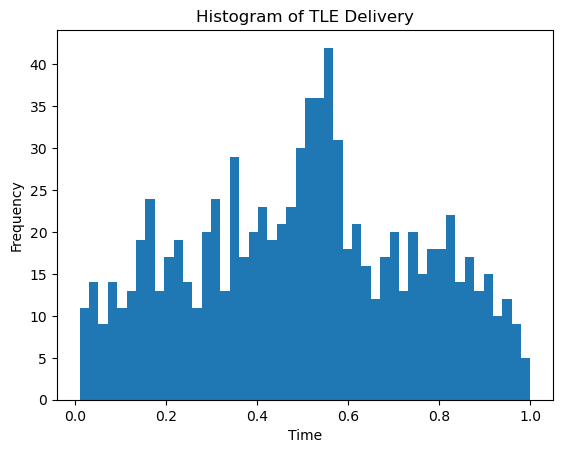

In [211]:
dates = justDateTime
# Create the histogram
plt.hist(dates, bins=48)

# Format the x-axis to display dates
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
# plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Histogram of TLE Delivery')

# Show the plot
plt.show()

In [199]:
x = 60*24
x

1440

[datetime.time(3, 54, 7), datetime.time(8, 43, 15), datetime.time(18, 21, 33), datetime.time(23, 10, 42), datetime.time(18, 27, 17), datetime.time(4, 5, 35), datetime.time(16, 56, 38), datetime.time(4, 11, 18), datetime.time(17, 2, 22), datetime.time(12, 18, 57), datetime.time(18, 44, 29), datetime.time(10, 48, 18), datetime.time(4, 28, 30), datetime.time(10, 54, 2), datetime.time(12, 30, 25), datetime.time(4, 34, 14), datetime.time(7, 21, 41), datetime.time(20, 38, 3), datetime.time(4, 39, 57), datetime.time(15, 54, 38), datetime.time(7, 58, 27), datetime.time(19, 18, 51), datetime.time(0, 7, 59), datetime.time(17, 48, 11), datetime.time(9, 52), datetime.time(19, 30, 17), datetime.time(1, 55, 49), datetime.time(21, 12, 23), datetime.time(8, 27, 3), datetime.time(8, 32, 46), datetime.time(10, 14, 52), datetime.time(18, 16, 46), datetime.time(10, 20, 34), datetime.time(12, 2, 40), datetime.time(13, 44, 45), datetime.time(4, 29, 15), datetime.time(10, 54, 46), datetime.time(18, 56, 40), 

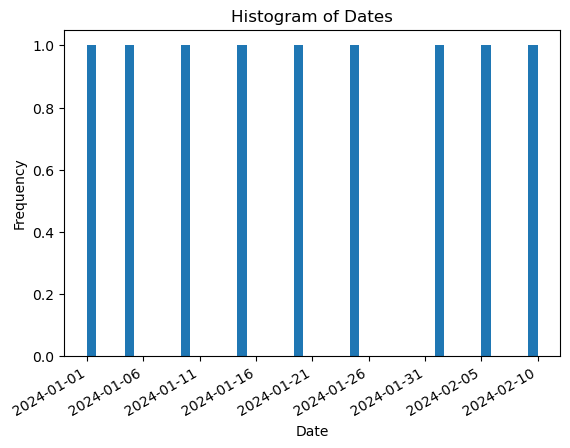

In [ ]:
justDateTime = []
import time

for timeobj in sat_mnvr_df["Time"]:
    if type(timeobj) != type(int)and type(timeobj) != type(float):
        justDateTime.append(timeobj)

print(justDateTime)


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Sample datetime data


TypeError: unsupported operand type(s) for +: 'int' and 'datetime.time'

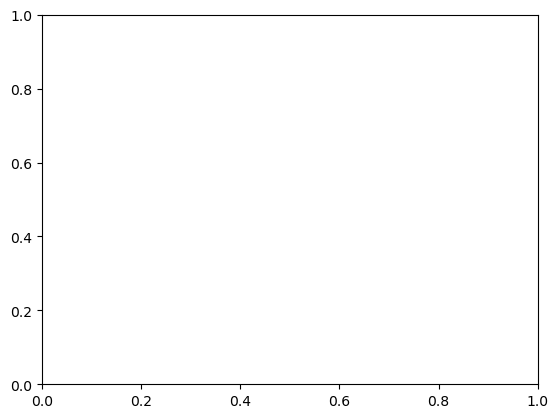

In [133]:
fig, ax = plt.subplots()
data = sat_mnvr_df['Time']
x_value = data.index 
y_value = data.values 
ax.bar(x_value, y_value, color=['r','y','c'])

ax.grid(axis='y',color='white')
ax.set_facecolor('black') 
ax.set_title('Character Use Totals',size=30) 
ax.set_xlabel('Character',size=20) 
ax.set_ylabel('Conglomerate Uses',size=20)
ax.set_xticklabels(labels=x_value,rotation=90)
fig.tight_layout()
fig.set_figwidth(17)
fig.set_figheight(10)

In [113]:
def seconds_since_midnight(pt):
    total_seconds = pt.sec + pt.minute*60 + pt.hour*3600
    return total_seconds

In [97]:
for i in range(0,len(timeoday)):
    timeoday.iloc[i] = seconds_since_midnight(timeoday.iloc[i])

AttributeError: 'int' object has no attribute 'sec'

c:\Users\Kevi6\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


TypeError: Invalid object type at position 0

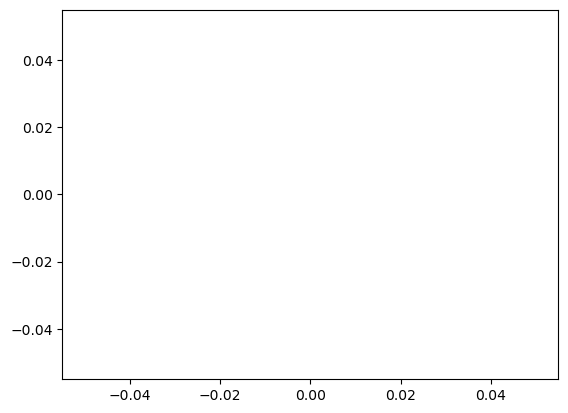

In [85]:
sb.histplot(data=timeoday[1:])